How to sample from imList (sampling bands or pixels?) and what do the 3 labels in the ground truth arrays mean? -- dont need no extension and .hdr files for ground truth - just use.txt file
-- probably sample bands

For i in image(WashingtonDC, Polymers):
    load image i
    load ground truth image i
    for c in clustering_algorithm(0,11):
        cluster image i with algorithm c
        evaluate clustering of image i with algorithm c against ground truth image i (use adjusted_mutual_information_score and adjusted_rand_score)
        plot scatterplot and cluster image (title: clustering algorithm c, evaluation score 1, evaluation score 2)
    table showing 2 evaluation scores for each of the 11 clustering algorithms


Is there a best performing method or group of methods?
Do the best performing methods (based on score) also provide visually good images/scatterplots?

In [1]:
# Common useful packages
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import copy
import spectral

# module that is useful for reloading packages
import importlib

# Scripts associated with the SML4SI textbook
import hyperspectral_gta_data as hsi_data
import scripts_M2 as sm2

In [2]:
# To download and use the Washington DC image:
hsi_data.download('WashingtonDC')
fname = 'spectral_images/WashingtonDC_Ref_156bands/WashingtonDC_Ref_156bands'

# Open the image and read into an array
im = spectral.envi.open(fname+'.hdr', fname)
wl = np.asarray(im.bands.centers)
# Load the image into memory
imArr = im.load()
print(f'Shape of ImArr = {imArr.shape}')

# To work with the data, we usually reshape the data from an image (# rows, # cols, # bands)
# into a standard (# observations, # features) array as (# pixels, # bands)
imList = np.reshape(imArr, (im.nrows*im.ncols, im.nbands))
print(f'Shape of imList = {imList.shape}')

Shape of ImArr = (1280, 307, 156)
Shape of imList = (392960, 156)


In [17]:
from sklearn import cluster, datasets, mixture

# define the model
model = cluster.MiniBatchKMeans(
        n_clusters=8,
        random_state=42,
    )
# fit the model
model.fit(imList)
# assign a cluster to each example
yhat = model.predict(imList)
print(yhat.shape)

(392960,)


In [11]:
# load the associated ground truth image
fname = '../spectral_images/WashingtonDC_groundTruth/WashDCclassLocations.txt'
file1 = open(fname, 'r')
Lines = file1.readlines()

# Strips the newline character
groundtruth_classes = {}
class_names = []

classIndex = 0
idx = 0
x = 0
for line in Lines:
    
    if line[0]==';':
        line = line.strip()
        #  reading the header info
        if line[:11] == '; ROI name:':
            name = line[12:]
            class_names.append(name)
            groundtruth_classes[name] = {'classIndex': classIndex, 'locations': []}
            classIndex = classIndex + 1
        if line[:11] == 'ROI npts:':
            groundtruth_classes[name]['npts'] = float(line[12:])
            
    else:
        line = line.strip()
        # reading the data
        if len(line)==0:
            # blank line - swtch to next class (aka ROI)
            idx = idx + 1
        else:
            loc = line.split(' ') # read the locations, split by spaces
            loc = [i for i in loc if i != '']  # remove blank spaces
            loc = [loc[2],loc[1]] # get the x and y coords
            groundtruth_classes[class_names[idx]]['locations'].append(loc)

# Iterate throught the classes and color the ground truth image for each pixel in the ground truth:
gt_im = np.zeros((im.nrows,im.ncols))
for key in groundtruth_classes.keys():
    print(f'Name: {key}')
    idx = groundtruth_classes[key]['classIndex']
    print(f'Index: {idx}')
    locations = groundtruth_classes[key]['locations'] #pull out x and y values
    print(f'Number of points: {len(locations)}')
    print(' ')
    for x,y in locations:
        gt_im[int(x),int(y)] = int(idx)

gt_list = np.reshape(gt_im, (im.nrows*im.ncols))

Name: water
Index: 0
Number of points: 11857
 
Name: red_roof
Index: 1
Number of points: 666
 
Name: grass_dry
Index: 2
Number of points: 3865
 
Name: grass_healthy
Index: 3
Number of points: 2506
 
Name: trees
Index: 4
Number of points: 1592
 
Name: copper_roods
Index: 5
Number of points: 677
 
Name: gravel_walkway
Index: 6
Number of points: 361
 
Name: road
Index: 7
Number of points: 1234
 


In [18]:
print(gt_list.shape)
max(gt_list)

(392960,)


np.float64(7.0)

In [58]:
#DBScan - 2 minutes for full data -- how are we supposed to compare dbscan to the known clusters if we can't specify the number of clusters??
# define the model
model = cluster.DBSCAN(eps=3, min_samples=100)

# fit the model
yhat = model.fit_predict(imList)                 ###Doesn't provide 7 clusters so the metrics are going to be way off
# assign a cluster to each example
print(yhat)

[-1 -1 -1 ... -1 -1 -1]


In [59]:
from sklearn import metrics
amis = metrics.adjusted_mutual_info_score(yhat, gt_list)
print(amis)
ars = metrics.adjusted_rand_score(yhat, gt_list)
print(ars)

0.0
0.0


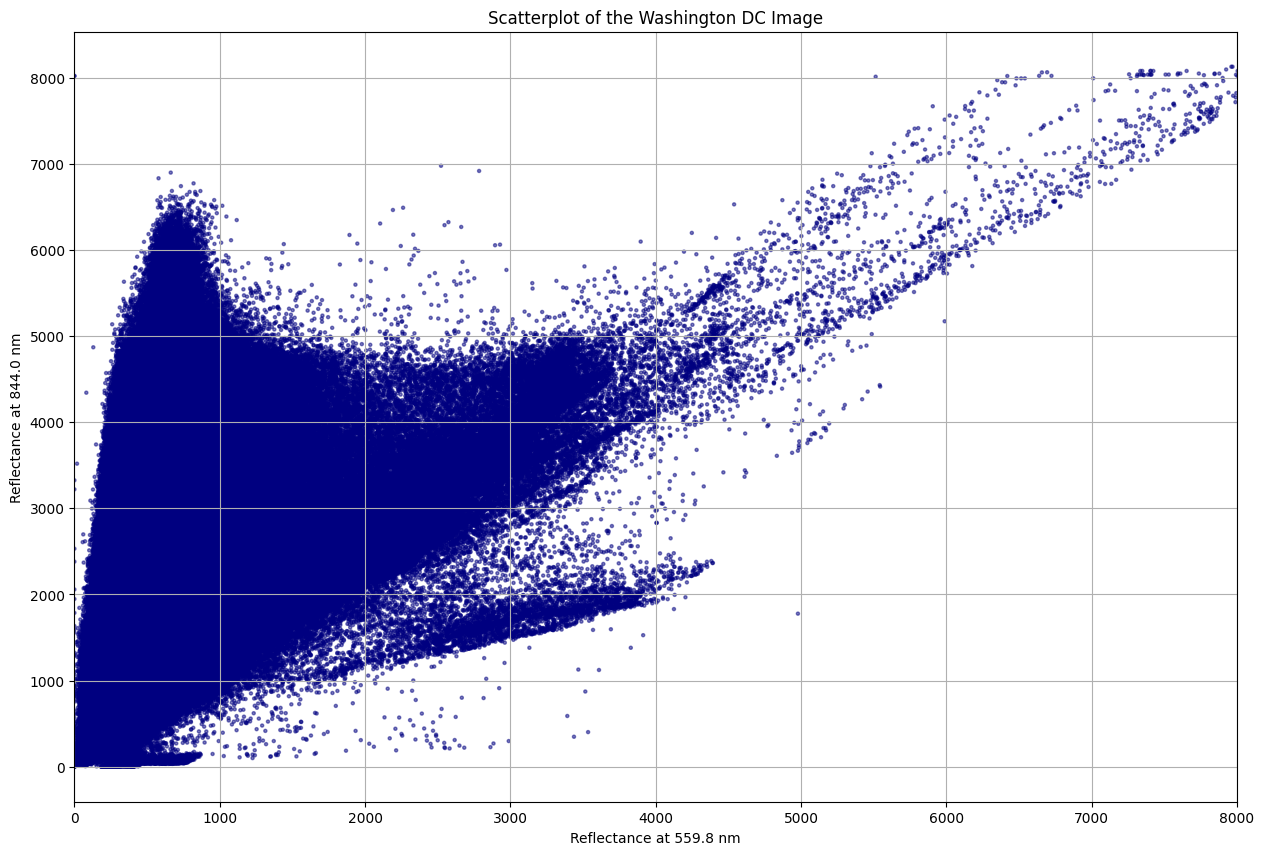

In [60]:
# Create a scatterplot of the data, colored by class
i1 = 30
i2 = 60

plt.figure(figsize=(15,10))
plt.scatter(imList[:,i1], imList[:,i2], s=5, c=yhat, alpha=0.5, cmap='jet');
plt.xlim(0,8000)
plt.grid(True)
plt.xlabel(f'Reflectance at {wl[i1]:.1f} nm')
plt.ylabel(f'Reflectance at {wl[i2]:.1f} nm')
plt.title('Scatterplot of the Washington DC Image');

Text(0.5, 1.0, 'Class Image')

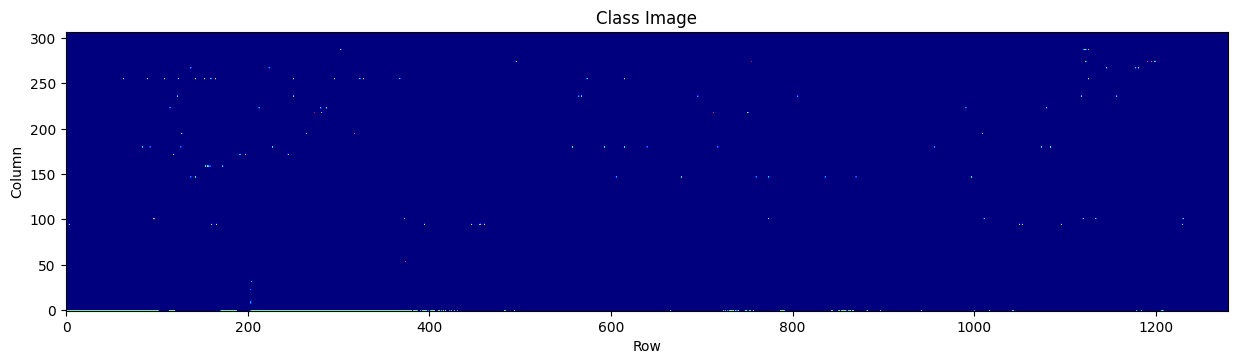

In [57]:
# Display the image, with each pixel colored by class
class_image = np.reshape(yhat, (im.nrows, im.ncols))

plt.figure(figsize=(15,5)) 
plt.imshow(np.flip(np.rot90(class_image), axis=0), cmap='jet');
plt.gca().invert_yaxis()  
plt.xlabel('Row');
plt.ylabel('Column');
plt.title('Class Image')

In [38]:
image = ['DC']
algorithms = ['minibatch', 'dbscan']
amis_var = [amis]
ars_var = [ars]

import pandas as pd
table = pd.DataFrame({'image':image, 'algorithm':algorithms, 'amis':amis_var, 'ars':ars_var})
table

,image,algorithm,amis,ars
0,DC,minibatch,0.035883,-0.00285


In [8]:
#- takes pver 2 min even with imList[:, :3]

bandwidth = cluster.estimate_bandwidth(imList, quantile=params["quantile"])
model = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)

# fit the model
model.fit(imList)
# assign a cluster to each example
yhat = model.predict(imList[:, :3])
print(yhat)

KeyboardInterrupt: 

In [7]:
# define the model
model = cluster.MiniBatchKMeans(
        n_clusters=params["n_clusters"],
        random_state=params["random_state"],
    )
# fit the model
model.fit(imList)
# assign a cluster to each example
yhat = model.predict(imList)
print(yhat)

2


In [4]:
# define the model 


model = cluster.SpectralClustering(
    n_clusters=params["n_clusters"],
    eigen_solver="arpack",
    affinity="nearest_neighbors",
    random_state=params["random_state"],
)

# fit the model
model.fit(imList[:, :3])
# assign a cluster to each example
yhat = model.predict(imList[:, :3])
print(yhat)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


KeyboardInterrupt: 

In [6]:
from sklearn.neighbors import kneighbors_graph #- takes over 2.5 min even with imList[:, :3]


#Ward
connectivity = kneighbors_graph(imList[:, :3], n_neighbors=params["n_neighbors"], include_self=False)
connectivity = 0.5 * (connectivity + connectivity.T)

# define the model - takes forever even with imList[:, :3]
model = cluster.AgglomerativeClustering(
    n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity)

# fit the model
model.fit(imList[:, :3])
# assign a cluster to each example
yhat = model.predict(imList[:, :3])
print(yhat)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:323: UserWarning: the number of connected components of the connectivity matrix is 17602 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


KeyboardInterrupt: 

In [53]:
#DBScan - 2 minutes for full data -- how are we supposed to compare dbscan to the known clusters if we can't specify the number of clusters??
# define the model
model = cluster.DBSCAN(eps=3, min_samples=100)

# fit the model
yhat = model.fit_predict(imList[:, :3])
# assign a cluster to each example
print(yhat)

[ 0 -1 -1 ... -1 -1 -1]


In [54]:
from collections import Counter

Counter(yhat).keys()


dict_keys([np.int64(0), np.int64(-1), np.int64(1)])

In [ ]:
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

X = imList.copy()

#Mean Shift
bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])
ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)

#nKMeans
two_means = cluster.MiniBatchKMeans(
    n_clusters=params["n_clusters"],
    random_state=params["random_state"],)

#Ward
connectivity = kneighbors_graph(X, n_neighbors=params["n_neighbors"], include_self=False)
connectivity = 0.5 * (connectivity + connectivity.T)
ward = cluster.AgglomerativeClustering(
    n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity)

#Spectral Clustering
spectral = cluster.SpectralClustering(
    n_clusters=params["n_clusters"],
    eigen_solver="arpack",
    affinity="nearest_neighbors",
    random_state=params["random_state"],
)

#DBScan
dbscan = cluster.DBSCAN(eps=params["eps"]
)

#HDBScan
hdbscan = cluster.HDBSCAN(
    min_samples=params["hdbscan_min_samples"],
    min_cluster_size=params["hdbscan_min_cluster_size"],
    allow_single_cluster=params["allow_single_cluster"],
)

#Optics
optics = cluster.OPTICS(
    min_samples=params["min_samples"],
    xi=params["xi"],
    min_cluster_size=params["min_cluster_size"],
)

#Affinity Propagation
affinity_propagation = cluster.AffinityPropagation(
    damping=params["damping"],
    preference=params["preference"],
    random_state=params["random_state"],
)

#Average Linkage
average_linkage = cluster.AgglomerativeClustering(
    linkage="average",
    metric="cityblock",
    n_clusters=params["n_clusters"],
    connectivity=connectivity,
)

#Birch
birch = cluster.Birch(n_clusters=params["n_clusters"]
)

#GMM
gmm = mixture.GaussianMixture(
    n_components=params["n_clusters"],
    covariance_type="full",
    random_state=params["random_state"],
)

In [23]:
images = [('a','b'),('c','d')]
for i in images:
    print(i[1])
    print(i[0])

b
a
d
c


In [15]:
images = [('../spectral_images/WashingtonDC_Ref_156bands/WashingtonDC_Ref_156bands','../spectral_images/WashingtonDC_groundTruth/WashingtonDC_classImage_groundtruth'),('../spectral_images/Microscene_Polymers/reflectance_image_polymers', '../spectral_images/Microscene_Polymers_groundTruth/reflectance_image_polymers_classImage_groundtruth')]
clustering_algorithms = []

for i in images:
    fname = i[0]
    # Open the image and read into an array
    im = spectral.envi.open(fname+'.hdr', fname)
    wl = np.asarray(im.bands.centers)
    # Load the image into memory
    imArr_image = im.load()
    print(f'Shape of ImArr = {imArr_image.shape}')
    imList_image = np.reshape(imArr_image, (im.nrows*im.ncols, im.nbands))
    print(f'Shape of imList = {imList_image.shape}')

    fname = i[1]
    # Open the image and read into an array
    im = spectral.envi.open(fname+'.hdr', fname)
    wl = np.asarray(im.bands.centers)
    # Load the image into memory
    imArr_truth = im.load()
    print(f'Shape of ImArr_truth = {imArr_truth.shape}')
    imList_truth = np.reshape(imArr_truth, (im.nrows*im.ncols, im.nbands))
    print(f'Shape of imList_truth = {imList_truth.shape}')

Shape of ImArr = (1280, 307, 156)
Shape of imList = (392960, 156)
Shape of ImArr_truth = (1280, 307, 3)
Shape of imList_truth = (392960, 3)
Shape of ImArr = (852, 384, 452)
Shape of imList = (327168, 452)
Shape of ImArr_truth = (852, 384, 3)
Shape of imList_truth = (327168, 3)


In [51]:
imList[2, :]

array([ 54.,  59.,  41.,  53.,  48.,  83.,  52.,  91.,  98.,  76.,  64.,
        66.,  99.,  72.,  85., 100.,  88.,  94.,  93., 115., 113., 122.,
       119., 103., 125., 135., 153., 184., 183., 192., 190., 193., 187.,
       178., 161., 164., 137., 124., 122., 124., 112., 105.,  88.,  80.,
        71.,  67.,  54.,  29.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         1.,   0.,   9.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   7.,   3.,   2.,   3.,   0.,   7.,   7.,   9.,   9.,   7.,
         8.,  10.,   9.,   5.,  14.,   9.,  10.,   8.,   9.,  10.,   9.,
         8.,  11.,  10.,  12.,  13.,  17.,  10.,   5.,  11.,  10.,   9.,
        12.,  11.,  11.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         4.,   0.,   0.,   4.,   0.,   4.,   0.,  13.,   4.,   5.,   0.,
         5.,  17.,  19.,   6.,   6.,  22.,   7.,   0.,   0.,   8.,  26.,
         0.,  32.,  10.,  28.,  34.,   0.,  11.,   

In [ ]:
For i in image(WashingtonDC, Polymers):
    load image i
    load ground truth image i
    for c in clustering_algorithm(0,11):
        cluster image i with algorithm c
        evaluate clustering of image i with algorithm c against ground truth image i (use adjusted_mutual_information_score and adjusted_rand_score)
        plot scatterplot and cluster image (title: clustering algorithm c, evaluation score 1, evaluation score 2)
    table showing 2 evaluation scores for each of the 11 clustering algorithms


Is there a best performing method or group of methods?
Do the best performing methods (based on score) also provide visually good images/scatterplots?

11 Clustering algorithms: 

        https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html

Adjusted_mutual_information_score and adjusted_rand_score:

        https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_mutual_info_score.html#sklearn.metrics.adjusted_mutual_info_score

        https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html#sklearn.metrics.adjusted_rand_score

Plots:

        https://github.com/wbasener/Machine-Learning-for-Spectral-Imaging/blob/main/Book%20Modules/Clustering%20Starter%20Code.ipynb

In [53]:
import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler


# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
    "allow_single_cluster": True,
    "hdbscan_min_cluster_size": 15,
    "hdbscan_min_samples": 3,
    "random_state": 42,
}

datasets = [
    (imList[:, :5], {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X = dataset

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(
        n_clusters=params["n_clusters"],
        random_state=params["random_state"],
    )
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
        random_state=params["random_state"],
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    hdbscan = cluster.HDBSCAN(
        min_samples=params["hdbscan_min_samples"],
        min_cluster_size=params["hdbscan_min_cluster_size"],
        allow_single_cluster=params["allow_single_cluster"],
    )
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"],
        preference=params["preference"],
        random_state=params["random_state"],
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        metric="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"],
        covariance_type="full",
        random_state=params["random_state"],
    )

    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan),
        ("HDBSCAN", hdbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
            print('done')
        else:
            y_pred = algorithm.predict(X)
            print('done')

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

KeyboardInterrupt: 